In [1]:
%matplotlib inline
%run 'notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *
import glob
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator

In [13]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
sessions = pd.read_csv('../stress-ng-6000-supermic/sessions.csv', index_col=0)
pilots = pd.read_csv('../stress-ng-6000-supermic/pilots.csv', index_col=0)
units = pd.read_csv('../stress-ng-6000-supermic/units.csv', index_col=0)

In [4]:
print 'Synapse: Weak Scaling: Total number of successful runs: %s' % sessions.shape[0]
print 'Synapse: Weak Scaling: Total number of pilots: %s' % pilots.shape[0]
print 'Synapse: Weak Scaling: Total number of units: %s\n' % wrangler_units.shape[0]

Synapse: Weak Scaling: Total number of successful runs: 8
Synapse: Weak Scaling: Total number of pilots: 8
Synapse: Weak Scaling: Total number of units: 488



In [10]:
stress_s = sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING', 'util_u_pre_exec',
    'util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std'],
                 'util_u_eprep'        : ['mean','std'],
                 'util_u_equeue'       : ['mean','std'],
                 'util_u_exec_cu'      : ['mean','std'],
                 'util_u_exec_rp'      : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std']})

stress_s.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
stress_s.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
stress_s.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
stress_s.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
stress_s.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

stress_s.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
stress_s.rename({'U_AGENT_QUEUING'     :'agent_queueing'}, axis='columns', inplace=True)
stress_s.rename({'U_AGENT_SCHEDULING'  :'agent_scheduling'}, axis='columns', inplace=True)
stress_s.rename({'U_AGENT_QUEUING_EXEC':'agent_queue_exec'}, axis='columns', inplace=True)
stress_s.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)

stress_s.rename(index={i: '%s/%s' % (i-1, i*20) for i in stress_s.index.get_values()}, inplace=True)
stress_s

executor_spawning_cu           agent_queueing           pre_executables_cu            cu_prep           os_spawns_cu              ...            TTQ              agent_queue_exec                   TTX                     TTC             scheduler_queue_cu          
                         mean       std           mean       std               mean       std     mean       std         mean       std    ...           mean          std             mean       std        mean       std          mean         std               mean       std
nunit                                                                                                                                      ...                                                                                                                                    
16/340                1.34980  0.072691        0.01340  0.000141           0.025150  0.001909  0.06815  0.000495      0.10740  0.004950    ...        73.1515     0.978636          0.13780  0.000566  6006.62215  0.120844  1.537997e+09  137.344108            0.14020  0.000566
32/660                1.50080  0.078772        0.02545  0.000637           0.049450  0.002193  0.12955  0.010677      0.24410  0.052184    ...       110.4487     0.666519          0.28205  0.015486  6006.77340  0.059680  1.537997e+09   60.578899            0.28460  0.015415
64/1300               1.76490  0.053599        0.04610  0.001979           0.092701  0.002122  0.27560  0.000707      0.57685  0.101329    ...       175.5623    11.315405          0.57280  0.007213  6007.08550  0.036628  1.537998e+09   92.037726            0.57565  0.007142
128/2580              3.15105  0.076862        0.09640  0.004384           0.199151  0.001769  0.56670  0.033091      0.79335  0.001909    ...     15099.6302  4568.619459          1.98960  0.054023  6008.48560  0.329087  1.538072e+09  159.140179            1.99315  0.053811

[4 rows x 22 columns]

In [11]:
stress_p = pilots[
    ['nunit','util_p_total','util_p_boot','util_p_term','util_p_uexec']
        ].groupby(['nunit']).aggregate(
                {'util_p_total'        : ['mean','std'],
                 'util_p_boot'         : ['mean','std'],
                 'util_p_term'         : ['mean','std'],
                 'util_p_uexec'        : ['mean','std']})


# 'orte_dvm_start'  is not captured in APRUN

stress_p.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
stress_p.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
stress_p.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
stress_p.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)

stress_p.rename(index={i: '%s/%s' % (i-1, i*20) for i in stress_p.index.get_values()}, inplace=True)
stress_p

p_term        p_uexec           p_total     p_bootstraps    
           mean std       mean       std    mean std         mean std
nunit                                                                
16/340      NaN NaN  6070.3361  2.674136     NaN NaN          NaN NaN
32/660      NaN NaN  6073.8268  0.093197     NaN NaN          NaN NaN
64/1300     NaN NaN  6069.3542  3.480521     NaN NaN          NaN NaN
128/2580    NaN NaN  6068.2935  4.161606     NaN NaN          NaN NaN

In [15]:
keys = sessions['sid'].tolist()
values = sessions['nunit'].tolist()
nunits_dict = dict(zip(keys, values))

sids_list = units['sid'].tolist()
nunit = []

for i in sids_list:
    nunit.append(nunits_dict[i])

units['nunit']=nunit
units.set_index('sid')
stress_u = units[
    ['nunit','util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp','util_u_pre_exec']
        ].groupby(['nunit']).aggregate(
                {'util_u_eprep'          : ['mean','std'],
                 'util_u_equeue'         : ['mean','std'],
                 'util_u_exec_cu'        : ['mean','std'],
                 'util_u_exec_rp'        : ['mean','std'],
                 'util_u_pre_exec'       : ['mean','std']})

stress_u.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
stress_u.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
stress_u.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
stress_u.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
stress_u.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

stress_u.rename(index={i: '%s/%s' % (i-1, i*20) for i in stress_u.index.get_values()}, inplace=True)
stress_u

cu_prep           executor_spawning_cu           scheduler_queue_cu           pre_executables_cu           os_spawns_cu          
              mean       std                 mean       std               mean       std               mean       std         mean       std
nunit                                                                                                                                       
16/340    0.004009  0.000455             0.564612  0.069737           0.028644  0.017751           0.001650  0.000105     0.008935  0.003708
32/660    0.003926  0.000461             0.569909  0.063477           0.055985  0.033300           0.001611  0.000124     0.013464  0.014298
64/1300   0.004240  0.001510             0.583392  0.084010           0.106106  0.060299           0.001566  0.000098     0.018366  0.021888
128/2580  0.004393  0.002881             0.586803  0.042833           0.411803  0.364353           0.001608  0.000154     0.007930  0.000622

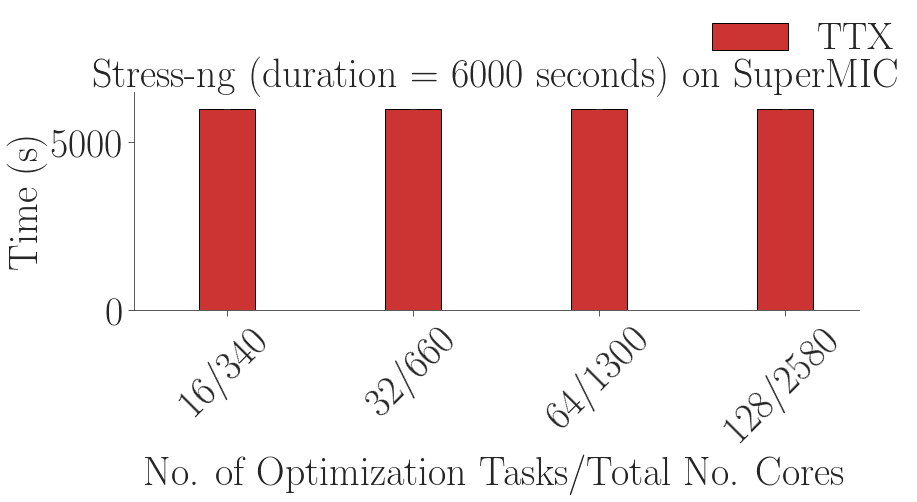

In [24]:
fig, ax = fig_setup(figsize=(13,4))

# Plot means and std bars
# sws['TTC'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
#     legend=False)

# sws['TTQ'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
#     legend=False)

width = 0.3
ax = stress_s['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=width, color=tableau20[6], ax=ax, rot=45, # position=-0.5, secondary_y=True,
    title='Stress-ng (duration = 6000 seconds) on SuperMIC',
    legend=False)


# ax2 = RP_OVERHEAD_ws.reset_index().plot(kind='bar',
#     x='nunit', y='mean', yerr='std', 
#     color=tableau20[3], width=width, ax=ax, rot=0, position=-0.5, secondary_y=True,
#     legend=False)

#ax.set_ylim(0,300)
ax.set_xlim(-0.5)


ax.legend(["TTX"], bbox_to_anchor = (0.75,1))
# ax2.legend(["Overhead (Right Axis)"], bbox_to_anchor = (1.15,0.-0.3))

ax.set_xlabel('No. of Optimization Tasks/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,6500)
ax.set_xlim(-0.5)

plt.savefig('figures/stress-ng-6000-supermic.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/stress-ng-6000-supermic.png', dpi=300, bbox_inches='tight')